# ANLP Lab 4: Recurrent Neural Networks


# Task 1

The figure below shows an RNN with one input unit $x$, one logistic hidden unit $h$, and one linear output unit $y$. The RNN is unrolled in time for T = 0, 1, and 2. 

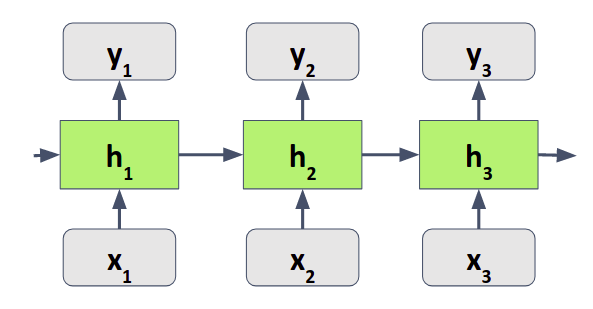

The network parameters are: 

$W_{xh} = 0.5,$

$W_{hh} = −1.0,$

$W_{hy} = −0.7,$

$h_{bias} = -1.0$ and,

$y_{bias} = 0.0.$

If the input $x$ takes the values 9, 4, −2 at time steps 0, 1, 2 respectively, what is the value of the output $y$ at T = 2? Give your answer to at least two digits after the decimal point.

Remember, 

$y_i = W_{hy}h_i + y_{bias}$

$h_i = \sigma(W_{xh}x_i + W_{hh}h_{i-1} + h_{bias})$

$\sigma(k)= \frac{1}{1+\exp(-k)}$


---

### Solution

$z_0 = W_{xh}x_0+h_{bias} = 0.5 * 9 + (-1.0) = 3.5$

$h_0 =  \sigma(z_0) = 1/(1 + exp(-3.5))=0.9706$

$y_0= W_{hy}h_0 + y_{bias}= -0.7 * 0.9706 + 0.0= -0.6794$


$z_1 = W_{xh}x_1+W_{hh}h_0 + h_{bias} = 0.5*4 + -1.0*0.9706 + (-1.0) = 0.0294$

$h_1= \sigma(z_1) =  1/(1 + exp(-0.0294))=0.5073$

$y_1= W_{hy}h_1 + y_{bias} = -0.7 * 0.5073 + 0.0 = -0.35511$



$z_2 = W_{xh}x_2+W_{hh}h_1 + h_{bias} = 0.5 * -2 + -1.0 *0.5073 + (-1.0) = -2.5073$

$h_2= \sigma(z_2) =  1/(1 + exp(2.4926))=0.0763$

$y_2 = W_{hy}h_2 + y_{bias}= -0.7 * 0.0763 + 0.0 = -0.05341$

#Task 2
### A step-by-step implementation of an RNN with LSTM using Keras

We will use the [Penn Tree Bank (PTB)](https://catalog.ldc.upenn.edu/LDC99T42) dataset as it is already split into train, validation and test datasets.

In [1]:
# Importing libraries
import os
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from keras.models import Sequential, load_model
from keras.layers import Dense, Activation, Embedding, TimeDistributed, LSTM
from keras.optimizers import Adam
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint

## Training Data and Preprocessing
 

### Text preprocessing functions

The following is some code to load the data, please examine it and refer to the [documentation for LabelEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html)

In [2]:
!wget www.fit.vutbr.cz/~imikolov/rnnlm/simple-examples.tgz
!tar -zxf  simple-examples.tgz
data_path = "simple-examples/data/"

--2021-03-06 19:01:50--  http://www.fit.vutbr.cz/~imikolov/rnnlm/simple-examples.tgz
Resolving www.fit.vutbr.cz (www.fit.vutbr.cz)... 147.229.9.23, 2001:67c:1220:809::93e5:917
Connecting to www.fit.vutbr.cz (www.fit.vutbr.cz)|147.229.9.23|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 34869662 (33M) [application/x-gtar]
Saving to: ‘simple-examples.tgz’

simple-examples.tgz 100%[===================>]  33.25M  18.6MB/s    in 1.8s    

2021-03-06 19:01:52 (18.6 MB/s) - ‘simple-examples.tgz’ saved [34869662/34869662]



In [3]:
def read_words(filename):
    with open(filename, "r") as f: 
       return f.read().replace("\n", "<eos>").split()

def load_data():
    # get the data
    train_words = read_words(data_path + "ptb.train.txt")
    valid_words = read_words(data_path + "ptb.valid.txt")
    test_words = read_words(data_path + "ptb.test.txt")

    # build a word2idx vocabulary
    le = LabelEncoder()
    le.fit(train_words + valid_words + test_words)
    train_data = le.transform(train_words)
    valid_data = le.transform(valid_words)
    test_data = le.transform(test_words)

    return train_data, valid_data, test_data, le

To call this function, we can run:

In [4]:
train_data, valid_data, test_data, encoder = load_data()

### Creating the Keras LSTM data generators

![alt text](https://cdn-images-1.medium.com/max/800/1*XvUt5wDQA8D3C0wAuxAvbA.png)

The training y data in our implementation is the input x words advanced one time step – in other words, at each time step the model is trying to predict the very next word in the sequence. 

When training neural networks, we generally feed data into them in small batches. Create a generator following these steps:


Parameters to know:
- *num_steps*: this is the number of words that we will feed into the time distributed input layer of the network. 
- *batch_size*: the size of the batch 
- *skip_steps* is the number of words we want to skip over between training samples within each batch
- reset *current_idx* to zero so that the data consumption starts from the beginning of the data set again 

In [5]:
class KerasBatchGenerator(object):

    def __init__(self, data, num_steps, batch_size, vocab_size, skip_step=5):
        self.data = data
        self.num_steps = num_steps
        self.batch_size = batch_size
        self.vocab_size = vocab_size
        # this will track the progress of the batches sequentially through the
        # data set - once the data reaches the end of the data set it will reset
        # back to zero
        self.current_idx = 0
        # skip_step is the number of words which will be skipped before the next
        # batch is skimmed from the data set
        self.skip_step = skip_step
        
    def generate(self):
      x = np.zeros((self.batch_size, self.num_steps))
      y = np.zeros((self.batch_size, self.num_steps, self.vocab_size))
      while True:
          for i in range(self.batch_size):
              if self.current_idx + self.num_steps >= len(self.data):
                # reset the index back to the start of the data set
                self.current_idx = 0
              x[i, :] = self.data[self.current_idx:self.current_idx + self.num_steps]
              temp_y = self.data[self.current_idx + 1:self.current_idx + self.num_steps + 1]
              # convert all of temp_y into a one hot representation
              y[i, :, :] = to_categorical(temp_y, num_classes=self.vocab_size)
              self.current_idx += self.skip_step
          yield x, y

Look at the initializer of the `KerasBatchGenerator` class.  Define the required hyperparameters of the model and instantialize the class for the training set and the validation set. Your train generator should return a batch of `batch_size` subseqences of length `num_steps` and as `y` the one-hot representation of the next word

In [6]:
num_steps = 10
batch_size = 10
hidden_size = 5
num_epochs = 5
vocab_size = len(encoder.classes_)

train_data_generator = KerasBatchGenerator(train_data, num_steps, batch_size, vocab_size, skip_step=num_steps)
valid_data_generator = KerasBatchGenerator(valid_data, num_steps, batch_size, vocab_size, skip_step=num_steps)

## Creating the Keras LSTM structure
Following the schema of the network above, add the various layers of the networks using `model.add()`. You network should consist of

* An embedding layer
* At least one LSTM layer
* A [time-distributed](https://keras.io/api/layers/recurrent_layers/time_distributed/) layer
* An output layer

In [8]:
model = Sequential()
model.add(Embedding(vocab_size, hidden_size, input_length=num_steps))
model.add(LSTM(hidden_size, return_sequences=True))
model.add(LSTM(hidden_size, return_sequences=True))
model.add(TimeDistributed(Dense(vocab_size)))
model.add(Activation('softmax'))

### Compiling and running the Keras LSTM model

The next step in Keras, once you’ve completed your model, is to run the compile command on the model. It looks like this:

In [9]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [10]:
checkpointer = ModelCheckpoint(filepath=data_path + 'model.hdf5', verbose=1)

In [11]:
model.fit_generator(train_data_generator.generate(), len(train_data)//(batch_size*num_steps), num_epochs,
                        validation_data=valid_data_generator.generate(),
                        validation_steps=len(valid_data)//(batch_size*num_steps), callbacks=[checkpointer])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/5
9295/9295 [==============================] - 249s 26ms/step - loss: 6.9642 - accuracy: 0.0514 - val_loss: 6.5443 - val_accuracy: 0.0559

Epoch 00001: saving model to simple-examples/data/model.hdf5
Epoch 2/5
9295/9295 [==============================] - 243s 26ms/step - loss: 6.5228 - accuracy: 0.0611 - val_loss: 6.3540 - val_accuracy: 0.0866

Epoch 00002: saving model to simple-examples/data/model.hdf5
Epoch 3/5
9295/9295 [==============================] - 246s 26ms/step - loss: 6.3415 - accuracy: 0.0942 - val_loss: 6.2307 - val_accuracy: 0.0986

Epoch 00003: saving model to simple-examples/data/model.hdf5
Epoch 4/5
9295/9295 [==============================] - 248s 27ms/step - loss: 6.2134 - accuracy: 0.1071 - val_loss: 6.0754 - val_accuracy: 0.1276

Epoch 00004: saving model to simple-examples/data/model.hdf5
Epoch 5/5
9295/9295 [==============================] - 245s 26ms/step - loss: 6.0506 - accuracy: 0.1313 - val_loss: 5.9558 - val_accuracy: 0.1382

Epoch 00005: saving m

`fit_generator` is a Keras function that can extract training data automatically from a pre-supplied Python iterator/generator object and input it to the model. 


---



# Task 3: text generation


## The Keras LSTM results

In order to test the trained Keras LSTM model, one can compare the predicted word outputs against what the actual word sequences are in the training and test data set.

In [13]:
model = load_model(data_path + '/model.hdf5')
reversed_dictionary = dict(zip(encoder.transform(encoder.classes_), encoder.classes_))
example_training_generator = KerasBatchGenerator(train_data, num_steps, 1, vocab_size, skip_step=1)
dummy_iters = 1

print("Training data...")
for i in range(dummy_iters):
    dummy = next(example_training_generator.generate())

num_predict = 10
true_print_out = "Actual words: "
pred_print_out = "Predicted words: "

for i in range(num_predict):
    data = next(example_training_generator.generate())
    prediction = model.predict(data[0])
    predict_word = np.argmax(prediction[:, num_steps-1, :])
    true_print_out += reversed_dictionary[train_data[num_steps + dummy_iters + i]] + " "
    pred_print_out += reversed_dictionary[predict_word] + " "

Training data...


In [14]:
print(true_print_out)
print(pred_print_out)

Actual words: kia memotec mlx nahb punts rake regatta rubens sim snack-food 
Predicted words: <eos> <eos> <eos> <eos> the <eos> <eos> <eos> <eos> <eos> 


How the output can get improved? Maybe tuning the hyperparmeters to make your model learn more or add a dropout layer?

#### Some ideas

1. More training epochs
2. Bigger hidden layer size
3. Stack more layers
4. Add a dropout layer to prevent overfitting
5. Use pre-trained word embeddings
6. Increase the seed sequence length
7. Randomize index resetting to skip different words at different passes (requires re-designing batch generator)

## Further reading

[The Unreasonable Effectiveness of Recurrent Neural Networks](http://karpathy.github.io/2015/05/21/rnn-effectiveness/)

[Understanding LSTM Networks](http://colah.github.io/posts/2015-08-Understanding-LSTMs/)

[LSTM in Keras tutorial](https://adventuresinmachinelearning.com/keras-lstm-tutorial/)

[RNNs in Tensorflow, a Practical Guide and Undocumented Features](http://www.wildml.com/2016/08/rnns-in-tensorflow-a-practical-guide-and-undocumented-features/)


